# System Identification With Order 2 and 3 Volterra Series

#### Volterra dynamic system identification model for prediction of all modalities, given all modelities exist as inputs

In [53]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
import glob
from collections import deque
import concurrent.futures
import math, decimal
from tqdm import tqdm_notebook
from random import shuffle
from sklearn import linear_model
import matplotlib.pyplot as plt
import pickle
import h5py
import seaborn as sns

### Show The Running Machine

In [3]:
import torch
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
else:
    print("Cuda is not available.")

GeForce RTX 2080 Ti


### Loading The Dataset (Trial by Trial)

In [4]:
# Get the participant data from Dataset directory
global t0, fs, dt, num_eeg_ch, num_emg_ch, num_force_ch, num_ch, num_conds
t0 = 0
fs = 1200
dt = 1.0/fs
num_eeg_ch = 14
num_emg_ch = 4
num_force_ch = 3
num_ch = num_eeg_ch + num_emg_ch + num_force_ch
num_conds = 18

# Get a list of files to process
data_files = list(map(loadmat, glob.glob("Dataset/*.mat")))

columns=['EEG-1','EEG-2','EEG-3','EEG-4','EEG-5',
         'EEG-6','EEG-7','EEG-8','EEG-9','EEG-10',
         'EEG-11','EEG-12','EEG-13','EEG-14','EMG-1',
         'EMG-2','EMG-3','EMG-4','Force-x', 
         'Force-y','Force-z']

glob.glob("Dataset/*.mat")

['Dataset/WC1200Hz.mat',
 'Dataset/P11200Hz.mat',
 'Dataset/JT1200Hz.mat',
 'Dataset/BT1200Hz.mat',
 'Dataset/YA1200Hz.mat',
 'Dataset/YZ1200Hz.mat',
 'Dataset/HCH1200Hz.mat',
 'Dataset/CC1200Hz.mat',
 'Dataset/ED1200Hz.mat',
 'Dataset/YK1200Hz.mat',
 'Dataset/KH1200Hz.mat']

In [4]:
def extract_data(file):
    data_splitBy_trials = [] # list of data frames, each df corresponding to a trial

    for cond in tqdm_notebook(range(num_conds), ascii=True):
        num_trials = file['EEGSeg_Ch'][0,0][0,cond].shape[0]
        # if a trial has long enough samples
        if file['EEGSeg_Ch'][0,0][0,cond].shape[1] >= 400:
            for trial in range(num_trials): 
                data = pd.DataFrame(columns=columns)
                for ch in range(num_eeg_ch):
                    data.iloc[:,ch] = file['EEGSeg_Ch'][0,ch][0,cond][trial,:]
                for ch in range(num_emg_ch):
                    data.iloc[:,ch+num_eeg_ch] = file['EMGSeg_Ch'][0,ch][0,cond][trial,:]
                for ch in range(num_force_ch):
                    data.iloc[:,ch+num_eeg_ch+num_emg_ch] = file['ForceSeg_Ch'][0,ch][0,cond][trial,:]

                # mean subtraction in each trial from the eeg and emg columns for removing dc drift
                data.iloc[:,:18] -= data.iloc[:,:18].mean()
                # convert volts to microvolts for EEG and EMG channels
                data.iloc[:,:18] *= 1e6
                # convert volts to milivolts for force channels
                data.iloc[:,18:] *= 1e3  
                data_splitBy_trials.append(data)
                
    train_data, test_data = train_test_split(data_splitBy_trials)
    return train_data, test_data


def train_test_split(data, train_ratio=0.5):
    shuffle(data) # shuffle list, in-place operator
    num_train = int(train_ratio*len(data))
    train_data, test_data = data[:num_train], data[num_train:]
    return train_data, test_data


train_data = [] # train data is a list (all participants each trial) of dataframes
test_data = [] # test data is a list (each participant) of list (each trial) of dataframes 

print('Reading and processing in parallel.')

# Create a pool of processes. By default, one is created for each CPU in your machine.
with concurrent.futures.ProcessPoolExecutor() as executor:
    # Process the list of files, but split the work across the process pool to use all CPUs.
    # executor.map() function takes in the helper function to call and the list of data to process with it.
    # executor.map() function returns results in  the same order as the list of data given to the process.
    for train, test in tqdm_notebook(executor.map(extract_data, data_files), total=len(data_files)):
        train_data.extend(train)
        test_data.append(test)
        
total_trials = len(train_data)
for test in test_data:
    total_trials += len(test)
print('Total number of trials of all the conditions in the file: %i' %total_trials) 
train_data[0].head(10) # first 10 samples of the first trial

Reading and processing in parallel.














Total number of trials of all the conditions in the file: 17648


,EEG-1,EEG-2,EEG-3,EEG-4,EEG-5,EEG-6,EEG-7,EEG-8,EEG-9,EEG-10,...,EEG-12,EEG-13,EEG-14,EMG-1,EMG-2,EMG-3,EMG-4,Force-x,Force-y,Force-z
0,23.167676,15.756166,16.982271,7.548239,12.165545,16.050811,17.137191,13.227083,9.266905,7.512412,...,11.071793,15.797413,-1.692378,330.187059,-27.502973,65.432741,23.912648,-109.325610,-108.847827,141.124114
1,23.388043,15.663438,17.082774,7.631282,11.843375,15.766723,16.879430,13.008864,9.280284,7.512905,...,10.780715,15.378491,-1.952203,372.457695,26.856463,72.639315,22.333125,-109.355651,-108.871542,141.092792
2,23.375689,16.079692,16.881640,8.375121,11.841599,15.110183,16.128607,13.034910,9.795444,8.026000,...,10.635129,15.264251,-1.816383,387.614039,41.563909,59.159702,53.029517,-109.079003,-108.597323,141.407490
3,23.117547,16.968430,16.375178,9.692186,12.141716,14.098265,14.904380,13.286291,10.747573,8.983246,...,10.625847,15.440065,-1.319323,411.775341,33.800404,11.972148,84.321955,-108.313240,-107.825555,142.278150
4,22.607069,18.259958,15.572219,11.457832,12.698434,12.763784,13.251260,13.724284,12.041608,10.289564,...,10.726951,15.869341,-0.521487,425.944948,30.060213,-1.020151,113.543132,-107.062548,-106.577970,143.656656
5,21.843903,19.856290,14.492529,13.520832,13.442912,11.152268,11.234785,14.293043,13.559942,11.830745,...,10.897771,16.496071,0.495415,437.147827,-21.468003,-16.771261,4.943470,-105.229937,-104.768403,145.656779
6,20.833954,21.638484,13.165325,15.715646,14.288552,9.318883,8.936981,14.924068,15.172012,13.482282,...,11.086708,17.249268,1.635170,426.127487,72.915952,-84.849660,6.150464,-103.179686,-102.705583,147.981331
7,19.589768,23.475570,11.627494,17.875457,15.138274,7.325171,6.450980,15.541790,16.744681,15.118633,...,11.236083,18.048420,2.794801,376.158771,208.203595,-73.512438,229.191044,-101.222873,-100.739405,150.205150
8,18.131030,25.234476,9.921857,19.844882,15.892970,5.235784,3.875166,16.069961,18.152512,16.622045,...,11.287999,18.809779,3.872869,284.776003,312.750142,-100.656649,432.189563,-99.488109,-99.002041,152.156293
9,16.485085,26.789877,8.095636,21.491034,16.460244,3.115665,1.307599,16.438218,19.287123,17.890394,...,11.190282,19.452967,4.777465,247.681891,155.468385,-144.824506,219.147662,-98.213434,-97.734556,153.576374


### Save Train and Test Data

In [ ]:
with open("train_data.txt", "wb") as fp:   #Pickling
    pickle.dump(train_data, fp)
    
with open("test_data.txt", "wb") as fp:   
    pickle.dump(test_data, fp)

### Load Train and Test Data

In [5]:
with open("train_data.txt", "rb") as fp:   # Unpickling
    train_data = pickle.load(fp)
    
with open("test_data.txt", "rb") as fp:   
    test_data = pickle.load(fp)

### Visualization of The Dataset

In [6]:
t0 = 0
fs = 1200
dt = 1.0/fs
trial_id = 40 # choose one trial
num_samples = train_data[trial_id].shape[0]
time = (np.arange(0, num_samples) * dt + t0) * 1e3
# pick one channel from eeg, emg and force
eeg_signal_1 = train_data[trial_id].iloc[:,0] # trial id, eeg_ch1
emg_signal_1 = train_data[trial_id].iloc[:,14] # trial id, emg_ch1
force_signal_3 = train_data[trial_id].iloc[:,20] # trial id, force_ch3

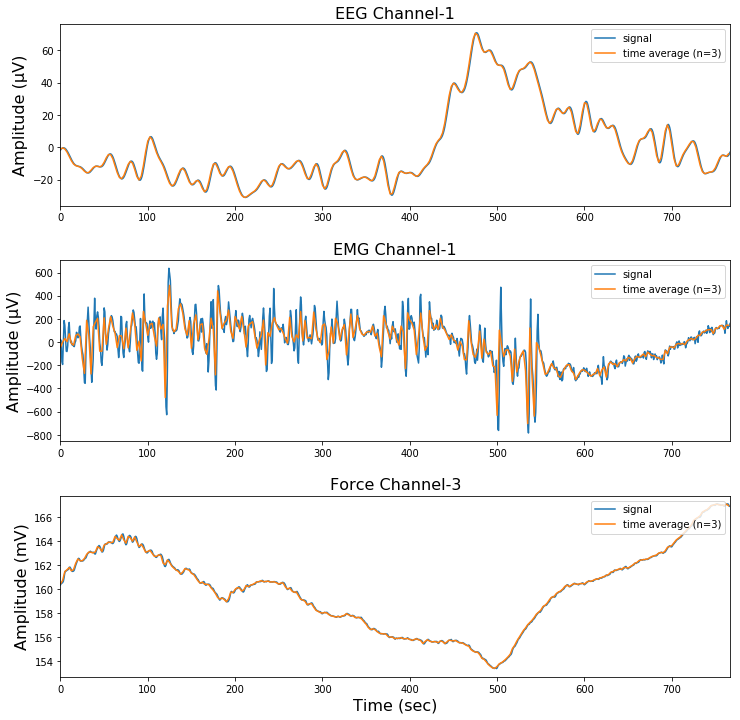

In [7]:
def get_ave_values(xvalues, yvalues, n):
    signal_length = len(xvalues)
    if signal_length % n == 0:
        padding_length = 0
    else:
        padding_length = n - signal_length//n % n
    xarr = np.array(xvalues)
    yarr = np.array(yvalues)
    xarr.resize(signal_length//n, n)
    yarr.resize(signal_length//n, n)
    xarr_reshaped = xarr.reshape((-1,n))
    yarr_reshaped = yarr.reshape((-1,n))
    x_ave = xarr_reshaped[:,0]
    y_ave = np.nanmean(yarr_reshaped, axis=1)
    return x_ave, y_ave

def plot_signal_plus_average(ax, time, signal, average_over):
    time_ave, signal_ave = get_ave_values(time, signal, average_over)
    ax.plot(time, signal, label='signal')
    ax.plot(time_ave, signal_ave, label = 'time average (n={})'.format(average_over))
    ax.set_xlim([time[0], time[-1]])
    ax.legend(loc='upper right')

fig, axes = plt.subplots(3, figsize=(12,12))
fig.subplots_adjust(hspace=0.3)
plot_signal_plus_average(axes[0], time, eeg_signal_1, average_over=3)

axes[0].set_ylabel('Amplitude (\u03bcV)', fontsize=16)
axes[0].set_title('EEG Channel-1', fontsize=16)
plot_signal_plus_average(axes[1], time, emg_signal_1, average_over=3)

axes[1].set_ylabel('Amplitude (\u03bcV)', fontsize=16)
axes[1].set_title('EMG Channel-1', fontsize=16)
plot_signal_plus_average(axes[2], time, force_signal_3, average_over=3)

axes[2].set_ylabel('Amplitude (mV)', fontsize=16)
axes[2].set_xlabel('Time (sec)', fontsize=16)
axes[2].set_title('Force Channel-3', fontsize=16)

plt.show()

## Volterra Series (Test Case)

### Volterra Series Order One

In [43]:
a = np.arange(125)
a = a.reshape((25,5))
input_df = pd.DataFrame({'Column1': a[:, 0], 'Column2': a[:, 1], 'Column3': a[:, 2],
                         'Column4': a[:, 3], 'Column5': a[:, 4]})

print(input_df)

def order_one_Volterra(input_df, M=5, dropnan=True):
    '''
    Assume a finite memory of M. 
    Given the input dataframe, show at each row variables at t-M, t-M+1, ... t variable values
    Also can be used for order 1 Volterra series input.
    '''
    n_vars = len(input_df.columns)
    cols, names = list(), list()
    cols.append(input_df.shift(0))
    names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    for i in range(M, 0, -1):
        cols.append(input_df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

order_one_Volterra(input_df).head(15)

    Column1  Column2  Column3  Column4  Column5
0         0        1        2        3        4
1         5        6        7        8        9
2        10       11       12       13       14
3        15       16       17       18       19
4        20       21       22       23       24
5        25       26       27       28       29
6        30       31       32       33       34
7        35       36       37       38       39
8        40       41       42       43       44
9        45       46       47       48       49
10       50       51       52       53       54
11       55       56       57       58       59
12       60       61       62       63       64
13       65       66       67       68       69
14       70       71       72       73       74
15       75       76       77       78       79
16       80       81       82       83       84
17       85       86       87       88       89
18       90       91       92       93       94
19       95       96       97       98  

,var1(t),var2(t),var3(t),var4(t),var5(t),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),...,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
5,25,26,27,28,29,0.0,1.0,2.0,3.0,4.0,...,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0
6,30,31,32,33,34,5.0,6.0,7.0,8.0,9.0,...,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0
7,35,36,37,38,39,10.0,11.0,12.0,13.0,14.0,...,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0
8,40,41,42,43,44,15.0,16.0,17.0,18.0,19.0,...,30.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0
9,45,46,47,48,49,20.0,21.0,22.0,23.0,24.0,...,35.0,36.0,37.0,38.0,39.0,40.0,41.0,42.0,43.0,44.0
10,50,51,52,53,54,25.0,26.0,27.0,28.0,29.0,...,40.0,41.0,42.0,43.0,44.0,45.0,46.0,47.0,48.0,49.0
11,55,56,57,58,59,30.0,31.0,32.0,33.0,34.0,...,45.0,46.0,47.0,48.0,49.0,50.0,51.0,52.0,53.0,54.0
12,60,61,62,63,64,35.0,36.0,37.0,38.0,39.0,...,50.0,51.0,52.0,53.0,54.0,55.0,56.0,57.0,58.0,59.0
13,65,66,67,68,69,40.0,41.0,42.0,43.0,44.0,...,55.0,56.0,57.0,58.0,59.0,60.0,61.0,62.0,63.0,64.0
14,70,71,72,73,74,45.0,46.0,47.0,48.0,49.0,...,60.0,61.0,62.0,63.0,64.0,65.0,66.0,67.0,68.0,69.0


### Volterra Series Order Two

In [44]:
def order_two_Volterra(input_df, M=5, dropnan=True):
    n_vars = len(input_df.columns)
    cols, names = list(), list()
    for i in range(M, 0, -1):
        for k in range(M, 0, -1):
            cols.append(input_df.shift(i)*input_df.shift(k))
            names += [('var%d(t-%d)(t-%d)' % (j+1, i, k)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

order_two_Volterra(input_df).head(15)

,var1(t-5)(t-5),var2(t-5)(t-5),var3(t-5)(t-5),var4(t-5)(t-5),var5(t-5)(t-5),var1(t-5)(t-4),var2(t-5)(t-4),var3(t-5)(t-4),var4(t-5)(t-4),var5(t-5)(t-4),...,var1(t-1)(t-2),var2(t-1)(t-2),var3(t-1)(t-2),var4(t-1)(t-2),var5(t-1)(t-2),var1(t-1)(t-1),var2(t-1)(t-1),var3(t-1)(t-1),var4(t-1)(t-1),var5(t-1)(t-1)
5,0.0,1.0,4.0,9.0,16.0,0.0,6.0,14.0,24.0,36.0,...,300.0,336.0,374.0,414.0,456.0,400.0,441.0,484.0,529.0,576.0
6,25.0,36.0,49.0,64.0,81.0,50.0,66.0,84.0,104.0,126.0,...,500.0,546.0,594.0,644.0,696.0,625.0,676.0,729.0,784.0,841.0
7,100.0,121.0,144.0,169.0,196.0,150.0,176.0,204.0,234.0,266.0,...,750.0,806.0,864.0,924.0,986.0,900.0,961.0,1024.0,1089.0,1156.0
8,225.0,256.0,289.0,324.0,361.0,300.0,336.0,374.0,414.0,456.0,...,1050.0,1116.0,1184.0,1254.0,1326.0,1225.0,1296.0,1369.0,1444.0,1521.0
9,400.0,441.0,484.0,529.0,576.0,500.0,546.0,594.0,644.0,696.0,...,1400.0,1476.0,1554.0,1634.0,1716.0,1600.0,1681.0,1764.0,1849.0,1936.0
10,625.0,676.0,729.0,784.0,841.0,750.0,806.0,864.0,924.0,986.0,...,1800.0,1886.0,1974.0,2064.0,2156.0,2025.0,2116.0,2209.0,2304.0,2401.0
11,900.0,961.0,1024.0,1089.0,1156.0,1050.0,1116.0,1184.0,1254.0,1326.0,...,2250.0,2346.0,2444.0,2544.0,2646.0,2500.0,2601.0,2704.0,2809.0,2916.0
12,1225.0,1296.0,1369.0,1444.0,1521.0,1400.0,1476.0,1554.0,1634.0,1716.0,...,2750.0,2856.0,2964.0,3074.0,3186.0,3025.0,3136.0,3249.0,3364.0,3481.0
13,1600.0,1681.0,1764.0,1849.0,1936.0,1800.0,1886.0,1974.0,2064.0,2156.0,...,3300.0,3416.0,3534.0,3654.0,3776.0,3600.0,3721.0,3844.0,3969.0,4096.0
14,2025.0,2116.0,2209.0,2304.0,2401.0,2250.0,2346.0,2444.0,2544.0,2646.0,...,3900.0,4026.0,4154.0,4284.0,4416.0,4225.0,4356.0,4489.0,4624.0,4761.0


### Volterra Series Order Three

In [45]:
def order_three_Volterra(input_df, M=5, dropnan=True):
    n_vars = len(input_df.columns)
    cols, names = list(), list()
    for i in range(M, 0, -1):
        for k in range(M, 0, -1):
            for l in range(M, 0, -1):
                cols.append(input_df.shift(i)*input_df.shift(k)*input_df.shift(l))
                names += [('var%d(t-%d)(t-%d)(t-%d)' % (j+1, i, k, l)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

order_three_Volterra(input_df).head(15)

,var1(t-5)(t-5)(t-5),var2(t-5)(t-5)(t-5),var3(t-5)(t-5)(t-5),var4(t-5)(t-5)(t-5),var5(t-5)(t-5)(t-5),var1(t-5)(t-5)(t-4),var2(t-5)(t-5)(t-4),var3(t-5)(t-5)(t-4),var4(t-5)(t-5)(t-4),var5(t-5)(t-5)(t-4),...,var1(t-1)(t-1)(t-2),var2(t-1)(t-1)(t-2),var3(t-1)(t-1)(t-2),var4(t-1)(t-1)(t-2),var5(t-1)(t-1)(t-2),var1(t-1)(t-1)(t-1),var2(t-1)(t-1)(t-1),var3(t-1)(t-1)(t-1),var4(t-1)(t-1)(t-1),var5(t-1)(t-1)(t-1)
5,0.0,1.0,8.0,27.0,64.0,0.0,6.0,28.0,72.0,144.0,...,6000.0,7056.0,8228.0,9522.0,10944.0,8000.0,9261.0,10648.0,12167.0,13824.0
6,125.0,216.0,343.0,512.0,729.0,250.0,396.0,588.0,832.0,1134.0,...,12500.0,14196.0,16038.0,18032.0,20184.0,15625.0,17576.0,19683.0,21952.0,24389.0
7,1000.0,1331.0,1728.0,2197.0,2744.0,1500.0,1936.0,2448.0,3042.0,3724.0,...,22500.0,24986.0,27648.0,30492.0,33524.0,27000.0,29791.0,32768.0,35937.0,39304.0
8,3375.0,4096.0,4913.0,5832.0,6859.0,4500.0,5376.0,6358.0,7452.0,8664.0,...,36750.0,40176.0,43808.0,47652.0,51714.0,42875.0,46656.0,50653.0,54872.0,59319.0
9,8000.0,9261.0,10648.0,12167.0,13824.0,10000.0,11466.0,13068.0,14812.0,16704.0,...,56000.0,60516.0,65268.0,70262.0,75504.0,64000.0,68921.0,74088.0,79507.0,85184.0
10,15625.0,17576.0,19683.0,21952.0,24389.0,18750.0,20956.0,23328.0,25872.0,28594.0,...,81000.0,86756.0,92778.0,99072.0,105644.0,91125.0,97336.0,103823.0,110592.0,117649.0
11,27000.0,29791.0,32768.0,35937.0,39304.0,31500.0,34596.0,37888.0,41382.0,45084.0,...,112500.0,119646.0,127088.0,134832.0,142884.0,125000.0,132651.0,140608.0,148877.0,157464.0
12,42875.0,46656.0,50653.0,54872.0,59319.0,49000.0,53136.0,57498.0,62092.0,66924.0,...,151250.0,159936.0,168948.0,178292.0,187974.0,166375.0,175616.0,185193.0,195112.0,205379.0
13,64000.0,68921.0,74088.0,79507.0,85184.0,72000.0,77326.0,82908.0,88752.0,94864.0,...,198000.0,208376.0,219108.0,230202.0,241664.0,216000.0,226981.0,238328.0,250047.0,262144.0
14,91125.0,97336.0,103823.0,110592.0,117649.0,101250.0,107916.0,114868.0,122112.0,129654.0,...,253500.0,265716.0,278318.0,291312.0,304704.0,274625.0,287496.0,300763.0,314432.0,328509.0


### Aggregate Volterra Series

In [46]:
# Volterra 3 series input is then the column-wise concatenation of 
# order 1, order2 and order 3 volterra.

agg1 = order_one_Volterra(input_df)
agg2 = order_two_Volterra(input_df)
agg3 = order_three_Volterra(input_df)
volterra_ord3 = agg1.join(agg2).join(agg3)
volterra_ord3.head(15)

,var1(t),var2(t),var3(t),var4(t),var5(t),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),...,var1(t-1)(t-1)(t-2),var2(t-1)(t-1)(t-2),var3(t-1)(t-1)(t-2),var4(t-1)(t-1)(t-2),var5(t-1)(t-1)(t-2),var1(t-1)(t-1)(t-1),var2(t-1)(t-1)(t-1),var3(t-1)(t-1)(t-1),var4(t-1)(t-1)(t-1),var5(t-1)(t-1)(t-1)
5,25,26,27,28,29,0.0,1.0,2.0,3.0,4.0,...,6000.0,7056.0,8228.0,9522.0,10944.0,8000.0,9261.0,10648.0,12167.0,13824.0
6,30,31,32,33,34,5.0,6.0,7.0,8.0,9.0,...,12500.0,14196.0,16038.0,18032.0,20184.0,15625.0,17576.0,19683.0,21952.0,24389.0
7,35,36,37,38,39,10.0,11.0,12.0,13.0,14.0,...,22500.0,24986.0,27648.0,30492.0,33524.0,27000.0,29791.0,32768.0,35937.0,39304.0
8,40,41,42,43,44,15.0,16.0,17.0,18.0,19.0,...,36750.0,40176.0,43808.0,47652.0,51714.0,42875.0,46656.0,50653.0,54872.0,59319.0
9,45,46,47,48,49,20.0,21.0,22.0,23.0,24.0,...,56000.0,60516.0,65268.0,70262.0,75504.0,64000.0,68921.0,74088.0,79507.0,85184.0
10,50,51,52,53,54,25.0,26.0,27.0,28.0,29.0,...,81000.0,86756.0,92778.0,99072.0,105644.0,91125.0,97336.0,103823.0,110592.0,117649.0
11,55,56,57,58,59,30.0,31.0,32.0,33.0,34.0,...,112500.0,119646.0,127088.0,134832.0,142884.0,125000.0,132651.0,140608.0,148877.0,157464.0
12,60,61,62,63,64,35.0,36.0,37.0,38.0,39.0,...,151250.0,159936.0,168948.0,178292.0,187974.0,166375.0,175616.0,185193.0,195112.0,205379.0
13,65,66,67,68,69,40.0,41.0,42.0,43.0,44.0,...,198000.0,208376.0,219108.0,230202.0,241664.0,216000.0,226981.0,238328.0,250047.0,262144.0
14,70,71,72,73,74,45.0,46.0,47.0,48.0,49.0,...,253500.0,265716.0,278318.0,291312.0,304704.0,274625.0,287496.0,300763.0,314432.0,328509.0


In [12]:
for col in volterra_ord3.columns:
    print(col)

var1(t)
var2(t)
var3(t)
var4(t)
var5(t)
var1(t-5)
var2(t-5)
var3(t-5)
var4(t-5)
var5(t-5)
var1(t-4)
var2(t-4)
var3(t-4)
var4(t-4)
var5(t-4)
var1(t-3)
var2(t-3)
var3(t-3)
var4(t-3)
var5(t-3)
var1(t-2)
var2(t-2)
var3(t-2)
var4(t-2)
var5(t-2)
var1(t-1)
var2(t-1)
var3(t-1)
var4(t-1)
var5(t-1)
var1(t-5)(t-5)
var2(t-5)(t-5)
var3(t-5)(t-5)
var4(t-5)(t-5)
var5(t-5)(t-5)
var1(t-5)(t-4)
var2(t-5)(t-4)
var3(t-5)(t-4)
var4(t-5)(t-4)
var5(t-5)(t-4)
var1(t-5)(t-3)
var2(t-5)(t-3)
var3(t-5)(t-3)
var4(t-5)(t-3)
var5(t-5)(t-3)
var1(t-5)(t-2)
var2(t-5)(t-2)
var3(t-5)(t-2)
var4(t-5)(t-2)
var5(t-5)(t-2)
var1(t-5)(t-1)
var2(t-5)(t-1)
var3(t-5)(t-1)
var4(t-5)(t-1)
var5(t-5)(t-1)
var1(t-4)(t-5)
var2(t-4)(t-5)
var3(t-4)(t-5)
var4(t-4)(t-5)
var5(t-4)(t-5)
var1(t-4)(t-4)
var2(t-4)(t-4)
var3(t-4)(t-4)
var4(t-4)(t-4)
var5(t-4)(t-4)
var1(t-4)(t-3)
var2(t-4)(t-3)
var3(t-4)(t-3)
var4(t-4)(t-3)
var5(t-4)(t-3)
var1(t-4)(t-2)
var2(t-4)(t-2)
var3(t-4)(t-2)
var4(t-4)(t-2)
var5(t-4)(t-2)
var1(t-4)(t-1)
var2(t-4)(t-1)
var3(

## Linear Regression Based On Volterra Series And One Step Ahead Predictions

In [13]:
# train data is a list of dataframes,
# for each trial, before finding the corresponding volterra series
# create an empty array with the correct size and than populating it 
num_train_trials = len(train_data)
# total num samples from all of the trials
num_all_samples = 0
for trial in train_data:
    num_all_samples += trial.shape[0]

k = len(train_data[0].columns) # number of features in the dataset
M = 5 # memory
d = 2 # volterra order

print("Total number of samples: %i" %num_all_samples)

Total number of samples: 4814986


In [15]:
# get a dataframe of volterra series for each trial in the train and test datasets

num_rows = num_all_samples - M*num_train_trials
test_volterra = [] # list is appended for each participant which is a list of numpy arrays(trials)
 
'''
return the aggregate volterra series
'''
def get_aggregate_volterra(input_df, order=2):
    agg1 = order_one_Volterra(input_df)
    agg2 = order_two_Volterra(input_df)
    if order == 2:
        return agg1.join(agg2)
    if order == 3:
        agg3 = order_three_Volterra(input_df)
        return agg1.join(agg2).join(agg3)

if d == 2:
    train_volterra = np.zeros((num_rows, k*(1+M+M**2)))
if d == 3:
    train_volterra = np.zeros((num_rows, k*(1+M+M**2+M**3)))

start = 0
end = 0
for i, trial in enumerate(tqdm_notebook(train_data, ascii=True)): 
    end = start + len(trial) - M
    train_volterra[start:end,:] = get_aggregate_volterra(trial).values[:,:] 
    start = end

### Save Volterra Series For Train Data

In [17]:
if d == 2:
    path = 'train_volterra_d2.h5'
if d == 3:
    path ='train_volterra_d3.h5'
    
hf_train_volterra = h5py.File(path, 'w') # requires about 125 gb for order 3 model
hf_train_volterra.create_dataset('dataset', data=train_volterra, chunks=True, compression='gzip')
hf_train_volterra.close()

### Load Volterra Series For Train Data

In [18]:
if d == 2:
    path = 'train_volterra_d2.h5'
if d == 3:
    path ='train_volterra_d3.h5'
    
hf = h5py.File(path, 'r')
train_volterra = np.array(hf.get('dataset'))
hf.close()

## MIMO Order 2 Volterra Series Kernel Learning 

In [19]:
train_volterra[:10,:]

array([[ 2.18439028e+01,  1.98562897e+01,  1.44925289e+01, ...,
         1.14623893e+04,  1.13588637e+04,  2.06372349e+04],
       [ 2.08339541e+01,  2.16384837e+01,  1.31653246e+01, ...,
         1.10733395e+04,  1.09764182e+04,  2.12158974e+04],
       [ 1.95897683e+01,  2.34755705e+01,  1.16274943e+01, ...,
         1.06460476e+04,  1.05484368e+04,  2.18984743e+04],
       ...,
       [ 1.08329142e+01,  2.92924334e+01,  2.41702556e+00, ...,
         9.35298914e+03,  9.26254468e+03,  2.40990456e+04],
       [ 8.89523625e+00,  2.92425329e+01,  6.45354030e-01, ...,
         9.27238679e+03,  9.18251232e+03,  2.42386985e+04],
       [ 7.04482603e+00,  2.87566054e+01, -9.67559192e-01, ...,
         9.21272029e+03,  9.12601854e+03,  2.43420918e+04]])

In [20]:
train_volterra.shape

(4770876, 651)

In [26]:
# alpha is the complexity parameter that controls the amount of shrinkage: 
# the larger the value of , the greater the amount of shrinkage and 
# thus the coefficients become more robust to collinearity.
# for alpha=0, ridge regression is same as OLS solution

classifiers = []
for k in tqdm_notebook(range(len(train_data[0].columns)), ascii=True):
    clf = linear_model.Ridge(alpha=.1, copy_X=True, fit_intercept=True, max_iter=None,
                             normalize=False, random_state=None, solver='auto', tol=0.001)
    X = train_volterra[:,len(train_data[0].columns):]
    Y = train_volterra[:,k]
    clf.fit(X, Y)
    classifiers.append(clf)

### Save The Classifiers

In [28]:
if d == 2:
    path = 'models_d2.h5'
if d == 3:
    path ='models_d3.h5'
    
with open(path, "wb") as fp:   #Pickling
    pickle.dump(classifiers, fp)

### Load The Classifiers

In [29]:
if d == 2:
    path = 'models_d2.h5'
if d == 3:
    path ='models_d3.h5'
    
with open(path, "rb") as fp:   
    classifiers = pickle.load(fp)

## One-Step-Ahead Predictions On The Test Data 

In [102]:
participant_id = 8
trial = 123
test_data[participant_id][trial].head(10)

,EEG-1,EEG-2,EEG-3,EEG-4,EEG-5,EEG-6,EEG-7,EEG-8,EEG-9,EEG-10,...,EEG-12,EEG-13,EEG-14,EMG-1,EMG-2,EMG-3,EMG-4,Force-x,Force-y,Force-z
0,11.172495,9.906304,8.183386,5.469978,10.026749,5.411751,13.101759,5.271709,7.384106,13.638465,...,6.465120,9.529604,17.550970,-2076.578438,149.435679,-616.918304,213.825070,-460.023493,-461.359888,-198.734596
1,11.231420,10.179886,8.812767,7.074219,10.494218,5.612990,13.266267,5.341786,6.682698,12.692010,...,6.660906,9.319198,16.893660,-1888.780035,173.664967,-320.677166,126.727783,-459.953159,-461.337566,-198.768392
2,11.693834,10.847950,9.872570,9.206766,11.353098,6.220426,13.791612,5.850335,6.348856,11.913641,...,7.234725,9.442563,16.486787,-1877.298690,-44.458230,-174.576869,-49.955286,-459.840536,-461.422890,-198.823988
3,12.495120,11.837241,11.294004,11.705740,12.547150,7.201719,14.647703,6.779158,6.399590,11.366192,...,8.166683,9.882083,16.355065,-2085.256502,-147.395452,-749.336076,19.916259,-459.768772,-461.518794,-198.785454
4,13.541842,13.051120,12.982864,14.386290,13.995254,8.497069,15.777316,8.076647,6.824068,11.088842,...,9.409945,10.599587,16.497785,-2287.540697,77.671687,-1094.898894,121.020638,-459.776133,-461.604357,-194.633827
5,14.720240,14.379105,14.827691,17.056141,15.598369,10.024059,17.101050,9.661725,7.585413,11.094450,...,10.894232,11.539596,16.889271,-2108.490206,166.691224,-132.943024,48.928820,-459.833235,-461.628228,-153.898731
6,15.906680,15.707386,16.709317,19.533297,17.247922,11.684365,18.524329,11.430582,8.624735,11.369388,...,12.531429,12.633911,17.481614,-1561.707929,-60.581287,-221.023788,106.283390,-459.892243,-461.582899,-79.675987
7,16.978949,16.929364,18.510911,21.661576,18.835149,13.371953,19.945939,13.265548,9.866924,11.875855,...,14.222758,13.807214,18.209603,-1354.081668,-113.152583,-1246.768036,311.695897,-459.979147,-461.460173,-29.180832
8,17.827184,17.955103,20.127438,23.323722,20.260255,14.982016,21.267184,15.045268,11.227611,12.556449,...,15.867000,14.983122,18.997308,-1602.283791,-219.636281,-622.714856,-127.724446,-460.060626,-461.381853,-10.786779
9,18.363597,18.718627,21.473715,24.450290,21.440476,16.419605,22.400612,16.655162,12.620659,13.340473,...,17.368851,16.090203,19.765449,-1512.735262,-189.833959,-16.948195,-280.446447,-460.041970,-461.386651,-35.095852


In [103]:
volterra_trial = get_aggregate_volterra(test_data[participant_id][trial]).values
test_predictions = np.zeros((volterra_trial.shape[0], len(train_data[0].columns)))

for k in tqdm_notebook(range(len(train_data[0].columns)), ascii=True):
    test_predictions[:,k] = classifiers[k].predict(volterra_trial[:,len(train_data[0].columns):])

columns=['EEG-1','EEG-2','EEG-3','EEG-4','EEG-5',
         'EEG-6','EEG-7','EEG-8','EEG-9','EEG-10',
         'EEG-11','EEG-12','EEG-13','EEG-14','EMG-1',
         'EMG-2','EMG-3','EMG-4','Force-x', 
         'Force-y','Force-z']
test_predictions = pd.DataFrame(data=test_predictions, columns=columns)
test_predictions.head(10)

,EEG-1,EEG-2,EEG-3,EEG-4,EEG-5,EEG-6,EEG-7,EEG-8,EEG-9,EEG-10,...,EEG-12,EEG-13,EEG-14,EMG-1,EMG-2,EMG-3,EMG-4,Force-x,Force-y,Force-z
0,14.723115,14.380287,14.828505,17.058188,15.599810,10.025611,17.102479,9.664166,7.584305,11.095948,...,10.894943,11.541600,16.890433,-2257.730468,266.623431,-1009.505265,217.084531,-460.116883,-461.575627,-186.897352
1,15.910167,15.709234,16.710823,19.534346,17.249945,11.686536,18.526503,11.433829,8.624016,11.371694,...,12.532816,12.636479,17.483410,-1877.500735,168.967165,237.457830,-6.811667,-455.560944,-461.449084,-88.271283
2,16.982768,16.931357,18.512621,21.663471,18.837251,13.374044,19.948089,13.269039,9.866318,11.878574,...,14.224606,13.809776,18.211565,-1232.253940,-156.141041,-492.678395,139.427306,-452.493675,-461.411660,-25.532284
3,17.830708,17.956682,20.128791,23.324513,20.261629,14.983422,21.268816,15.048221,11.226360,12.558757,...,15.868409,14.985372,18.998662,-1374.828668,76.411333,-1745.167334,452.417507,-409.473206,-461.757854,-17.231902
4,18.366589,18.720059,21.474962,24.450967,21.441682,16.420560,22.402002,16.657653,12.619163,13.342557,...,17.370115,16.091839,19.766569,-1695.944135,-268.611856,182.766478,-174.381464,-405.819172,-462.116270,-19.591325
5,18.533256,19.184405,22.492114,25.024628,22.317956,17.608647,23.279126,17.999795,13.964762,14.153733,...,18.648501,17.069723,20.440447,-1343.203379,-49.494238,-298.653345,-0.941508,-477.850266,-459.515701,-64.915919
6,18.304132,19.340664,23.147965,25.073371,22.856869,18.490893,23.854095,18.998893,15.191185,14.914996,...,19.639358,17.869041,20.954356,-1448.205375,-86.111148,-258.783807,160.261806,-482.234719,-461.632718,-116.148553
7,17.690444,19.209445,23.441884,24.676742,23.055824,19.041795,24.111154,19.612987,16.248427,15.560895,...,20.306408,18.462663,21.262887,-1416.591886,34.815684,109.320286,111.192994,-460.606464,-462.026074,-76.231860
8,16.734730,18.833281,23.398831,23.935632,22.937360,19.260667,24.060149,19.830386,17.101936,16.038435,...,20.637202,18.839538,21.338673,-758.007888,85.186479,-71.714647,314.047267,-461.168626,-459.257784,-83.743262
9,15.506402,18.271072,23.064733,22.979215,22.546796,19.172705,23.735145,19.671423,17.737693,16.312520,...,20.644985,19.005180,21.175952,-1486.714238,122.757883,-303.339224,317.471739,-465.600760,-460.866839,-69.122530


In [104]:
test_data[participant_id][trial].head(15)

,EEG-1,EEG-2,EEG-3,EEG-4,EEG-5,EEG-6,EEG-7,EEG-8,EEG-9,EEG-10,...,EEG-12,EEG-13,EEG-14,EMG-1,EMG-2,EMG-3,EMG-4,Force-x,Force-y,Force-z
0,11.172495,9.906304,8.183386,5.469978,10.026749,5.411751,13.101759,5.271709,7.384106,13.638465,...,6.465120,9.529604,17.550970,-2076.578438,149.435679,-616.918304,213.825070,-460.023493,-461.359888,-198.734596
1,11.231420,10.179886,8.812767,7.074219,10.494218,5.612990,13.266267,5.341786,6.682698,12.692010,...,6.660906,9.319198,16.893660,-1888.780035,173.664967,-320.677166,126.727783,-459.953159,-461.337566,-198.768392
2,11.693834,10.847950,9.872570,9.206766,11.353098,6.220426,13.791612,5.850335,6.348856,11.913641,...,7.234725,9.442563,16.486787,-1877.298690,-44.458230,-174.576869,-49.955286,-459.840536,-461.422890,-198.823988
3,12.495120,11.837241,11.294004,11.705740,12.547150,7.201719,14.647703,6.779158,6.399590,11.366192,...,8.166683,9.882083,16.355065,-2085.256502,-147.395452,-749.336076,19.916259,-459.768772,-461.518794,-198.785454
4,13.541842,13.051120,12.982864,14.386290,13.995254,8.497069,15.777316,8.076647,6.824068,11.088842,...,9.409945,10.599587,16.497785,-2287.540697,77.671687,-1094.898894,121.020638,-459.776133,-461.604357,-194.633827
5,14.720240,14.379105,14.827691,17.056141,15.598369,10.024059,17.101050,9.661725,7.585413,11.094450,...,10.894232,11.539596,16.889271,-2108.490206,166.691224,-132.943024,48.928820,-459.833235,-461.628228,-153.898731
6,15.906680,15.707386,16.709317,19.533297,17.247922,11.684365,18.524329,11.430582,8.624735,11.369388,...,12.531429,12.633911,17.481614,-1561.707929,-60.581287,-221.023788,106.283390,-459.892243,-461.582899,-79.675987
7,16.978949,16.929364,18.510911,21.661576,18.835149,13.371953,19.945939,13.265548,9.866924,11.875855,...,14.222758,13.807214,18.209603,-1354.081668,-113.152583,-1246.768036,311.695897,-459.979147,-461.460173,-29.180832
8,17.827184,17.955103,20.127438,23.323722,20.260255,14.982016,21.267184,15.045268,11.227611,12.556449,...,15.867000,14.983122,18.997308,-1602.283791,-219.636281,-622.714856,-127.724446,-460.060626,-461.381853,-10.786779
9,18.363597,18.718627,21.473715,24.450290,21.440476,16.419605,22.400612,16.655162,12.620659,13.340473,...,17.368851,16.090203,19.765449,-1512.735262,-189.833959,-16.948195,-280.446447,-460.041970,-461.386651,-35.095852


## Visualization Of Predictions Over Test Data

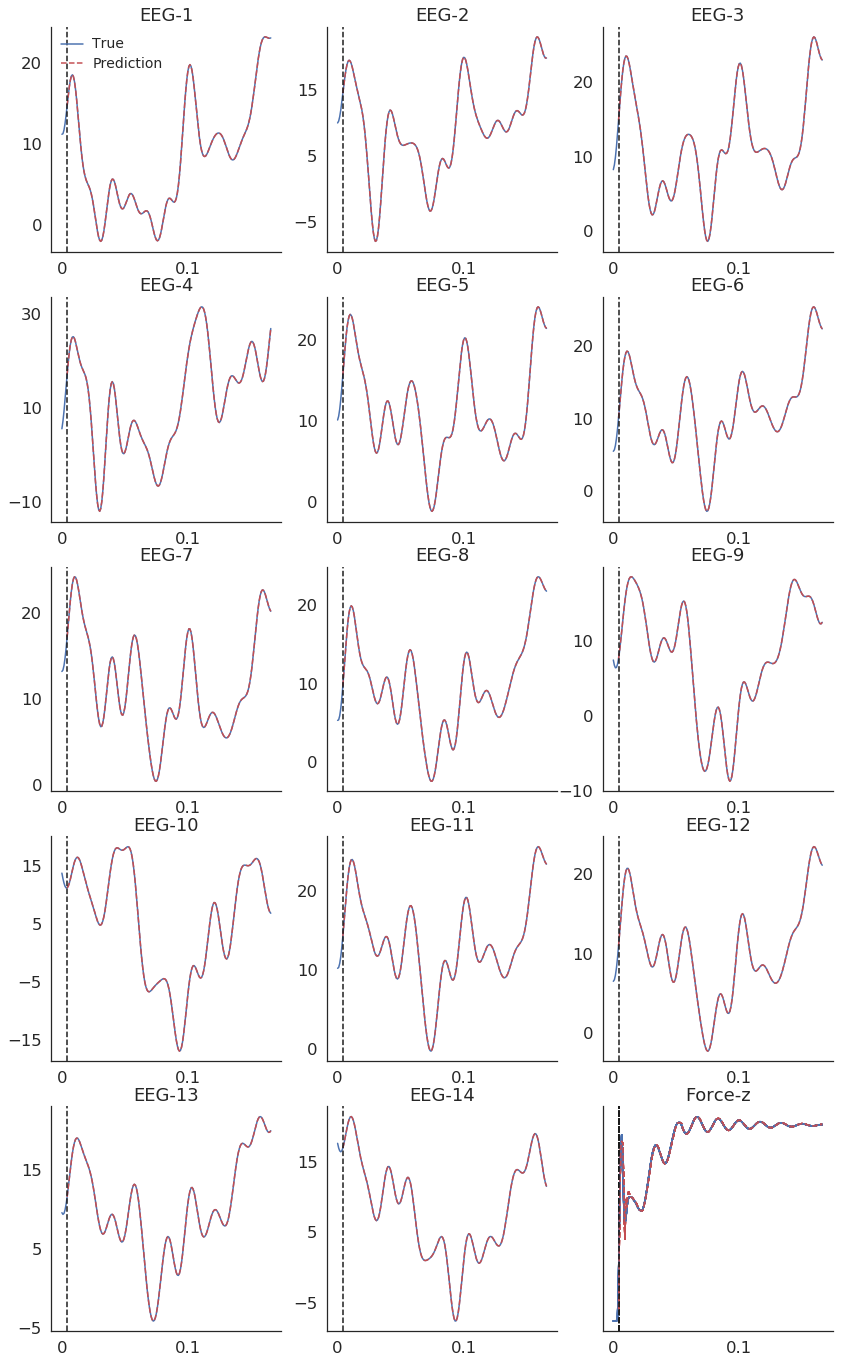

In [105]:
# Plot the predictions in time domain given thresholded DWT coeffs 
# for different combinations of eeg+emg+force:

nPreds = 195
P = 5
x_gt=np.arange(0, (nPreds+P)/fs, 1/fs)
x_pred=np.arange(P/fs, (nPreds+P)/fs, 1/fs)
T = math.floor(10*(nPreds+P)/fs) + 1

if T != 1:
    z = [decimal.Decimal(i) / decimal.Decimal(10) for i in range(0, T)]
else:
    T = math.floor(100*(nPreds+P)/fs) + 1
    z = [decimal.Decimal(i) / decimal.Decimal(100) for i in range(0, T, 2)]

sns.set(style="white", palette="muted", color_codes=True, font_scale=1.5)
# Set up the matplotlib figure (all forecasts subplot figure)
f, axes = plt.subplots(5, 3, figsize=(14, 24), sharex=False, sharey=False)
sns.despine()

plt.setp(axes, xticks=z, xticklabels=z)

for j in range(1,15,1):
    sns.set()
    axes[math.floor((j-1)/3),(j-1)%3].plot(x_gt, test_data[participant_id][trial].iloc[:nPreds+P,j-1].values, 
                                           color='b', label="True")
    axes[math.floor((j-1)/3), (j-1)%3].plot(x_pred, test_predictions.iloc[:nPreds,j-1].values, 
                                            color='r', linestyle='--', label="Prediction")
    axes[math.floor((j-1)/3), (j-1)%3].axvline(x=P/fs, linestyle='--', color='k')
    axes[math.floor((j-1)/3), (j-1)%3].title.set_text("EEG-%i" %j)
    axes[math.floor((j-1)/3), (j-1)%3].set_yticks(axes[math.floor((j-1)/3), (j-1)%3].get_yticks()[1:-1:2])
    axes[0, 0].legend(frameon=False)
    plt.setp(axes[0, 0].get_legend().get_texts(), fontsize='14')

    axes[4,2].plot(x_gt, test_data[participant_id][trial].iloc[:nPreds+P,-1].values, 
                   color='b', label="True")
    axes[4,2].plot(x_pred, test_predictions.iloc[:nPreds, -1].values, 
                   color='r', linestyle='--', label="Prediction")
    axes[4,2].axvline(x=P/fs, linestyle='--', color='k')
    axes[4,2].ticklabel_format(axis='y', style='sci', scilimits=(4,-4))
    axes[4,2].title.set_text("Force-z")
    axes[4,2].set_yticks(axes[4, 2].get_yticks()[1:-1:2])
    #axes[4,2].legend() 

plt.savefig("VolterraResults/predictions.pdf", bbox_inches="tight")